In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload

import bemcs

# Function to label open nodes, overlapping interior nodes and triple junctions automatically
def label_nodes(els):
    n_els = len(els.x1)
    # first find all unique points
    points = np.zeros((2 * n_els, 2))
    x1y1 = np.vstack((els.x1, els.y1)).T
    x2y2 = np.vstack((els.x2, els.y2)).T
    points[0::2, :] = x1y1
    points[1::2, :] = x2y2
    nvec = np.vstack((els.x_normals, els.y_normals)).T
    xmid = np.copy(els.x_centers)
    ymid = np.copy(els.y_centers)
    unique_points, id_unique = np.unique(points, axis=0, return_index=True)

    # Find number of open, 2-overlap & triple junction nodes
    index_matrix1 = []
    index_matrix2 = []
    index_matrix3 = []
    for i in range(len(unique_points)):
        pts = unique_points[i, :].reshape(1, -1)

        # Which element(s) contains this point
        id1 = np.where(np.all(pts == x1y1, axis=1))
        id2 = np.where(np.all(pts == x2y2, axis=1))

        # The negative signs are for the triple junction equations
        # s_1 + s_2 + s_3 = 0 with the negative sign going to any 2 elements that are both id1 or id2
        if np.size(id1) == 2:
            id_combo = np.hstack((-id1[0] * 3, id2[0] * 3 + 2))
        elif np.size(id2) == 2:
            id_combo = np.hstack((id1[0] * 3, -(id2[0] * 3 + 2)))
        else:
            id_combo = np.hstack((id1[0] * 3, id2[0] * 3 + 2))

        if np.size(id_combo) == 1:
            index_matrix1.append(id_combo)
        elif np.size(id_combo) == 2:
            index_matrix2.append(id_combo)
        elif np.size(id_combo) == 3:
            index_matrix3.append(id_combo)
        else:
            print(id_combo)
            raise ValueError("Cannot deal with more than 3 lines at a node")

    print("Number of open nodes =", len(index_matrix1))
    print(":", index_matrix1)
    print("Number of 2-overlap nodes =", len(index_matrix2))
    print(":", index_matrix2)
    print("Number of triple junctions =", len(index_matrix3))
    print(":", index_matrix3)

    return index_matrix1, index_matrix2, index_matrix3

['base' 'left_edge' 'mbt' 'mct' 'ramp_mft' 'right_edge' 'topo']


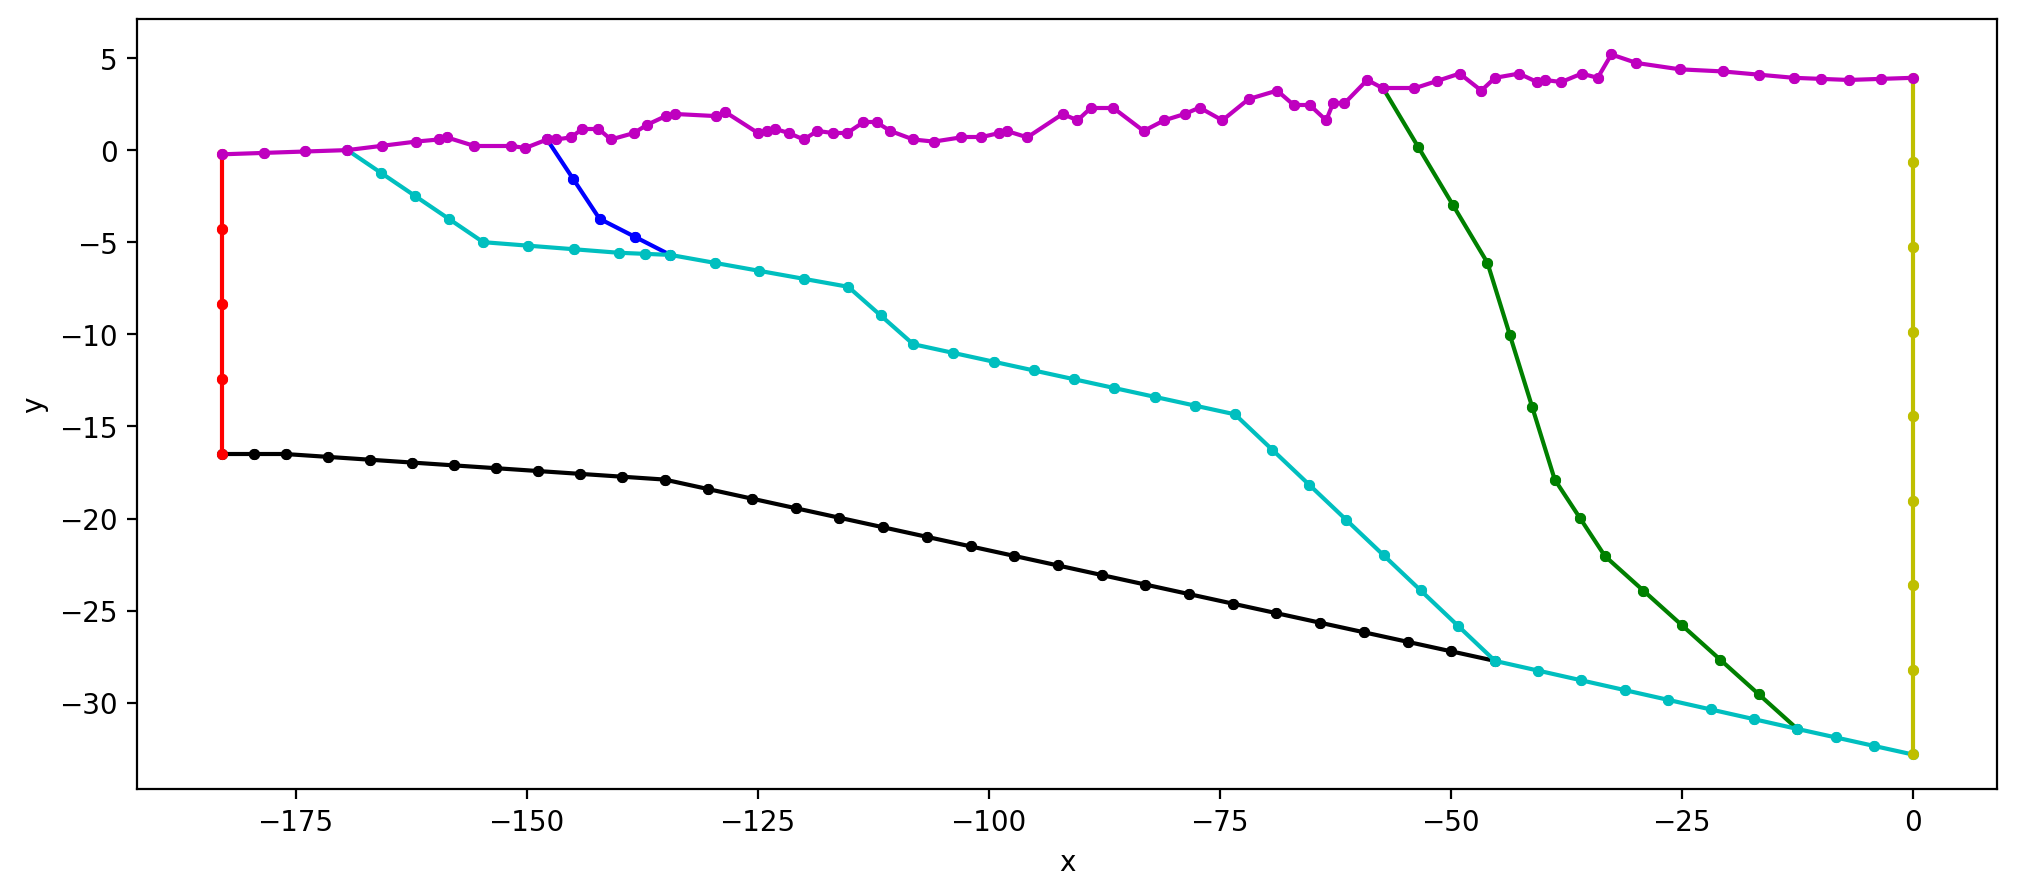

In [3]:
# Elastic parameters
mu = 1e3
nu = 0.25

# read fault geometry files
fileinput = pd.read_csv("mht_geometry_5_km.csv")
# print(fileinput.head())
x1 = fileinput["x1"].values
x2 = fileinput["x2"].values
y1 = fileinput["y1"].values
y2 = fileinput["y2"].values
bc_x = fileinput["bc_x"].values
bc_y = fileinput["bc_y"].values
bctype = fileinput["bc_type"].values

labels = fileinput["collection"].values
print(np.unique(labels))

# create bemcs data structure
els = bemcs.initialize_els()
els.x1 = x1
els.y1 = -y1
els.x2 = x2
els.y2 = -y2
bemcs.standardize_els_geometry(els)
n_els = len(els.x1)
# bemcs.plot_els_geometry(els)

plt.figure(figsize=(12, 5))
cval = "krbgcym"
count = 0
for i in np.unique(labels):
    index = np.where(labels == i)[0]
    for j in index:
        plt.plot(
            [els.x1[j], els.x2[j]], [els.y1[j], els.y2[j]], ".-", color=cval[count]
        )
    count += 1
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Identifying open nodes, overlapping interior nodes and triple junctions automatically

In [4]:
index_open, index_overlap, index_triple = label_nodes(els)
N_c = 2 * n_els  # central node equations
N_o = 2 * len(index_open)  # open node equations
N_i = 4 * len(index_overlap)  # overlapping node equations
N_t = 6 * len(index_triple)  # triple junction equations

Number of open nodes = 0
: []
Number of 2-overlap nodes = 169
: [array([-375, -498]), array([501, 500]), array([504, 503]), array([507, 506]), array([  0, 509]), array([372, 377]), array([3, 2]), array([369, 374]), array([6, 5]), array([366, 371]), array([363, 368]), array([381, 380]), array([12, 11]), array([360, 365]), array([384, 383]), array([15, 14]), array([18, 17]), array([21, 20]), array([387, 386]), array([357, 362]), array([24, 23]), array([390, 389]), array([354, 359]), array([27, 26]), array([30, 29]), array([393, 392]), array([351, 356]), array([36, 35]), array([39, 38]), array([240, 239]), array([396, 395]), array([348, 353]), array([42, 41]), array([45, 44]), array([243, 242]), array([48, 47]), array([399, 398]), array([345, 350]), array([51, 50]), array([246, 245]), array([402, 401]), array([54, 53]), array([342, 347]), array([57, 56]), array([60, 59]), array([339, 344]), array([408, 407]), array([63, 62]), array([66, 65]), array([336, 341]), array([69, 68]), array([411

In [5]:
Nequations = N_c + N_o + N_i + N_t
Nunknowns = 6 * n_els

# We will stack this with
# equations for the element centers
# equations at open nodes (RHS = 0)
# equations at overlapping nodes (RHS = 0)
# equations at triple junctions (RHS = 0)
BC_c = np.zeros((N_c, 1))  # these are the only non-zero entries
BC_o = np.zeros((N_o, 1))
BC_i = np.zeros((N_i, 1))
BC_t = np.zeros((N_t, 1))

# Boundary conditions are
# topography - traction-free (tx,ty) = (0,0)
# right_edge - velocity specified
# left_edge - (vx,vy) = (0,0)
# base - traction-free (tx,ty) = (0,0)
# what to do about mbt, mct, ramp_mft?
BC_c[0::2] = bc_x.reshape((-1, 1))
BC_c[1::2] = bc_y.reshape((-1, 1))

# stack all the BCs into 1 big vector
BCvector = np.vstack((BC_c, BC_o, BC_i, BC_t))

## Design Matrix System 
- At element centers, we implement either displacement or traction boundary conditions
- At open nodes, we force slip to be 0
- At 2-overlap (interior) nodes we have continuity & smoothness of slip
- At triple junctions, we implement 2 equations for conservation of slip and 4 equations for smoothness

We first deal with the matrix system for the central nodes

In [8]:
# Design matrices (in x,y coordinates) for slip and slip gradients at each 3qn
matrix_slip, matrix_slip_gradient = bemcs.get_matrices_slip_slip_gradient(els)

# Patch center locations (need to be shifted an infinitesimal amount in -ve unit normal direction)
obs_xy = np.vstack((els.x_centers, els.y_centers)).T
x_obs = obs_xy[:, 0].reshape(-1, 1)
y_obs = obs_xy[:, 1].reshape(-1, 1)

# Compute shear and tensile stress kernels evaluated ONLY at the center of each element
kernels_s = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "shear")
kernels_n = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "normal")

# Convert to traction kernels [Nobs x Ncoefficients]
traction_kernels_s = bemcs.get_traction_kernels(els, kernels_s, flag="global")
traction_kernels_n = bemcs.get_traction_kernels(els, kernels_n, flag="global")

# Linear Operators for the appropriate boundary conditions
matrix_system_c = np.zeros((N_c, Nunknowns))
matrix_system_o = np.zeros((N_o, Nunknowns))
matrix_system_i = np.zeros((N_i, Nunknowns))
matrix_system_t = np.zeros((N_t, Nunknowns))

/Users/mallick/Documents/GitHub/bemcs/bemcs/bemcs.py:149: RuntimeWarning: divide by zero encountered in divide
  arctan_x_plus_a = np.pi / 2 * np.sign(y / (a + x)) - np.arctan(y / (a + x))


### Assemble linear operator for central nodes only

In [12]:
# Linear operator for central node BCs
kerneleval_x = np.zeros((n_els, Nunknowns))
kerneleval_y = np.zeros((n_els, Nunknowns))

# x,y-kernels
for i in np.unique(labels):
    index = np.where(labels == i)[0]
    for j in index:
        if bctype[j] == "u":
            for k in range(0, 3):
                kerneleval_x[j, k::6] = kernels_s[3][j, k::3]
                kerneleval_x[j, k + 3 :: 6] = kernels_n[3][j, k::3]
                kerneleval_y[j, k::6] = kernels_s[4][j, k::3]
                kerneleval_y[j, k + 3 :: 6] = kernels_n[4][j, k::3]
        elif bctype[j] == "t":
            for k in range(0, 3):
                kerneleval_x[j, k::6] = traction_kernels_s[0][j, k::3]
                kerneleval_x[j, k + 3 :: 6] = traction_kernels_n[0][j, k::3]
                kerneleval_y[j, k::6] = traction_kernels_s[1][j, k::3]
                kerneleval_y[j, k + 3 :: 6] = traction_kernels_n[1][j, k::3]
        elif bctype[j] == "s":
            kerneleval_x[j, :] = matrix_slip[2::6, :][j, :]
            kerneleval_y[j, :] = matrix_slip[3::6, :][j, :]

# populate matrix_system for central nodes
matrix_system_c[0::2, :] = kerneleval_x
matrix_system_c[1::2, :] = kerneleval_y

### Open nodes, overlapping nodes & triple junctions

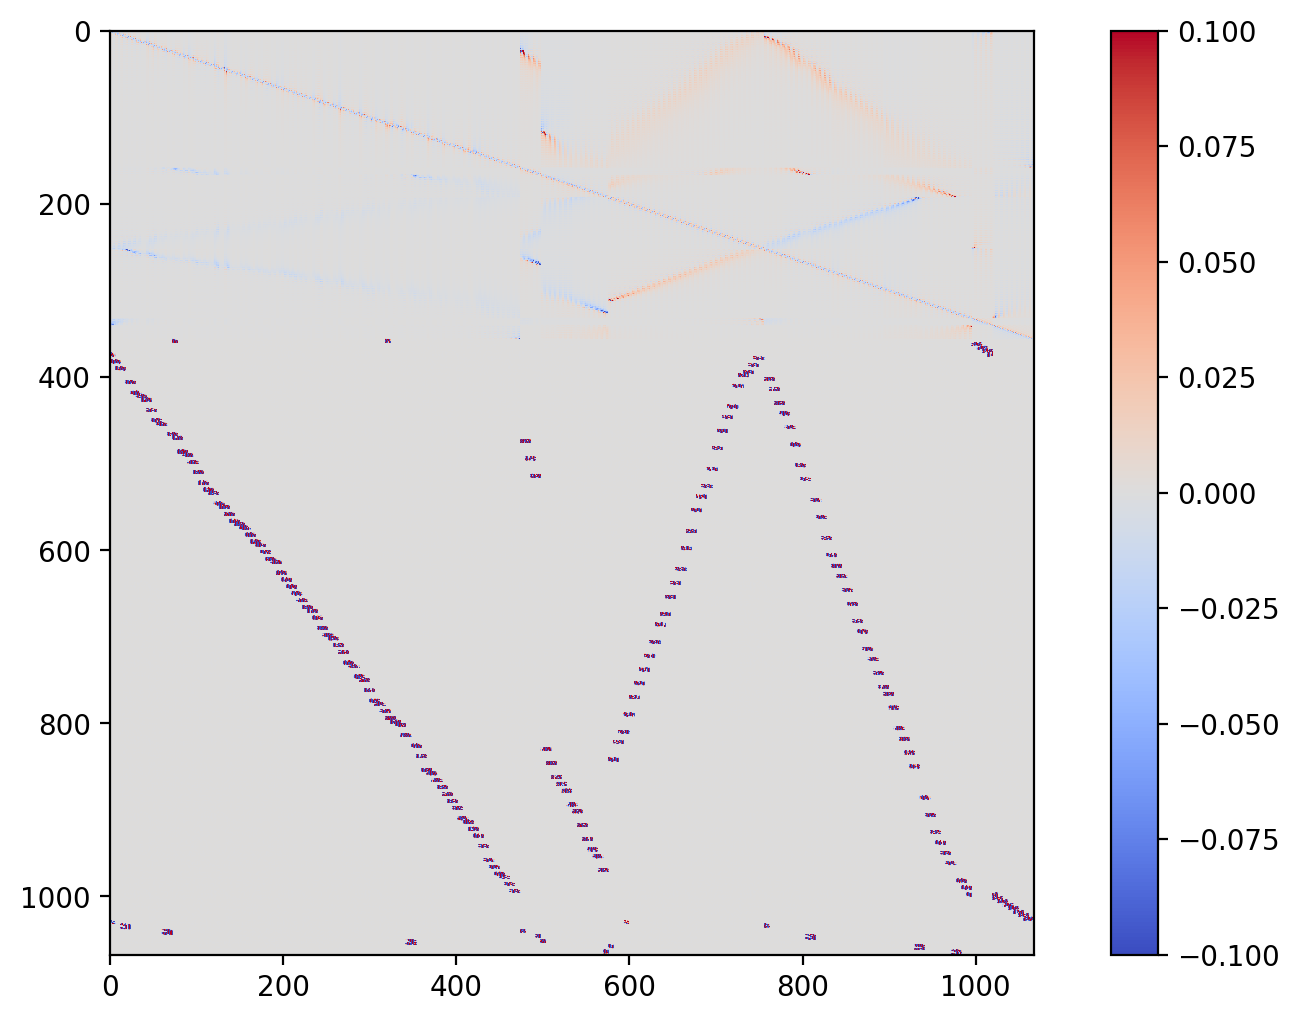

In [17]:
# Linear operator for open nodes
for i in range(int(N_o / 2)):
    id1 = index_open[i]  # node number
    matrix_system_o[2 * i, :] = matrix_slip[2 * id1, :]  # x component
    matrix_system_o[2 * i + 1, :] = matrix_slip[2 * id1 + 1, :]  # y component

# Linear operator for overlapping nodes
for i in range(int(N_i / 4)):
    idvals = index_overlap[i]  # node number
    # continuity condition
    matrix_system_i[4 * i, :] = (
        matrix_slip[2 * idvals[0], :] - matrix_slip[2 * idvals[1], :]
    )  # x
    matrix_system_i[4 * i + 1, :] = (
        matrix_slip[2 * idvals[0] + 1, :] - matrix_slip[2 * idvals[1] + 1, :]
    )  # y
    # smoothing constraints
    matrix_system_i[4 * i + 2, :] = (
        matrix_slip_gradient[2 * idvals[0], :] - matrix_slip_gradient[2 * idvals[1], :]
    )  # x
    matrix_system_i[4 * i + 3, :] = (
        matrix_slip_gradient[2 * idvals[0] + 1, :]
        - matrix_slip_gradient[2 * idvals[1] + 1, :]
    )  # y

# Linear operator for triple junction nodes
for i in range(int(N_t / 6)):
    id1 = index_triple[i]
    idvals = np.abs(id1)

    id_neg = idvals[id1 < 0]  # node number that need to be subtracted in TJ kinematics
    id_pos = idvals[id1 >= 0]  # node numbers that need to be added
    # triple junction kinematics equations
    if len(id_neg) == 2:
        matrix_system_t[6 * i, :] = (
            matrix_slip[2 * id_pos, :]
            - matrix_slip[2 * id_neg[0], :]
            - matrix_slip[2 * id_neg[1], :]
        )  # x component
        matrix_system_t[6 * i + 1, :] = (
            matrix_slip[2 * id_pos + 1, :]
            - matrix_slip[2 * id_neg[0] + 1, :]
            - matrix_slip[2 * id_neg[1] + 1, :]
        )  # y component
    else:
        matrix_system_t[6 * i, :] = (
            matrix_slip[2 * id_pos[0], :]
            + matrix_slip[2 * id_pos[1], :]
            - matrix_slip[2 * id_neg, :]
        )  # x component
        matrix_system_t[6 * i + 1, :] = (
            matrix_slip[2 * id_pos[0] + 1, :]
            + matrix_slip[2 * id_pos[1] + 1, :]
            - matrix_slip[2 * id_neg + 1, :]
        )  # y component

    # smoothing constraints (2 nodes at a time)
    matrix_system_t[6 * i + 2, :] = (
        matrix_slip_gradient[2 * idvals[0], :] - matrix_slip_gradient[2 * idvals[1], :]
    )  # x
    matrix_system_t[6 * i + 3, :] = (
        matrix_slip_gradient[2 * idvals[0] + 1, :]
        - matrix_slip_gradient[2 * idvals[1] + 1, :]
    )  # y
    matrix_system_t[6 * i + 4, :] = (
        matrix_slip_gradient[2 * idvals[0], :] - matrix_slip_gradient[2 * idvals[2], :]
    )  # x
    matrix_system_t[6 * i + 5, :] = (
        matrix_slip_gradient[2 * idvals[0] + 1, :]
        - matrix_slip_gradient[2 * idvals[2] + 1, :]
    )  # y

# stack the matrices and create the full linear operator
matrix_system = np.vstack(
    (matrix_system_c, matrix_system_o, matrix_system_i, matrix_system_t)
)

# plot design matrix
plt.figure(figsize=(10, 6))
plt.imshow(matrix_system, cmap="coolwarm")
plt.colorbar()
plt.clim(-0.1, 0.1)
plt.show()

# Solve system

In [19]:
# compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.pinv(matrix_system) @ BCvector
print("Linear Operator Condition Number:", np.linalg.cond(matrix_system))

# extract (s,n) components and store them in 2 separate vectors
quadratic_coefs_s = np.zeros((3 * n_els, 1))
quadratic_coefs_n = np.zeros((3 * n_els, 1))
for i in range(n_els):
    quadratic_coefs_s[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i : 6 * i + 3]
    quadratic_coefs_n[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i + 3 : 6 * (i + 1)]

Linear Operator Condition Number: 660754.9323816955


## Plot displacement and stress components in the medium

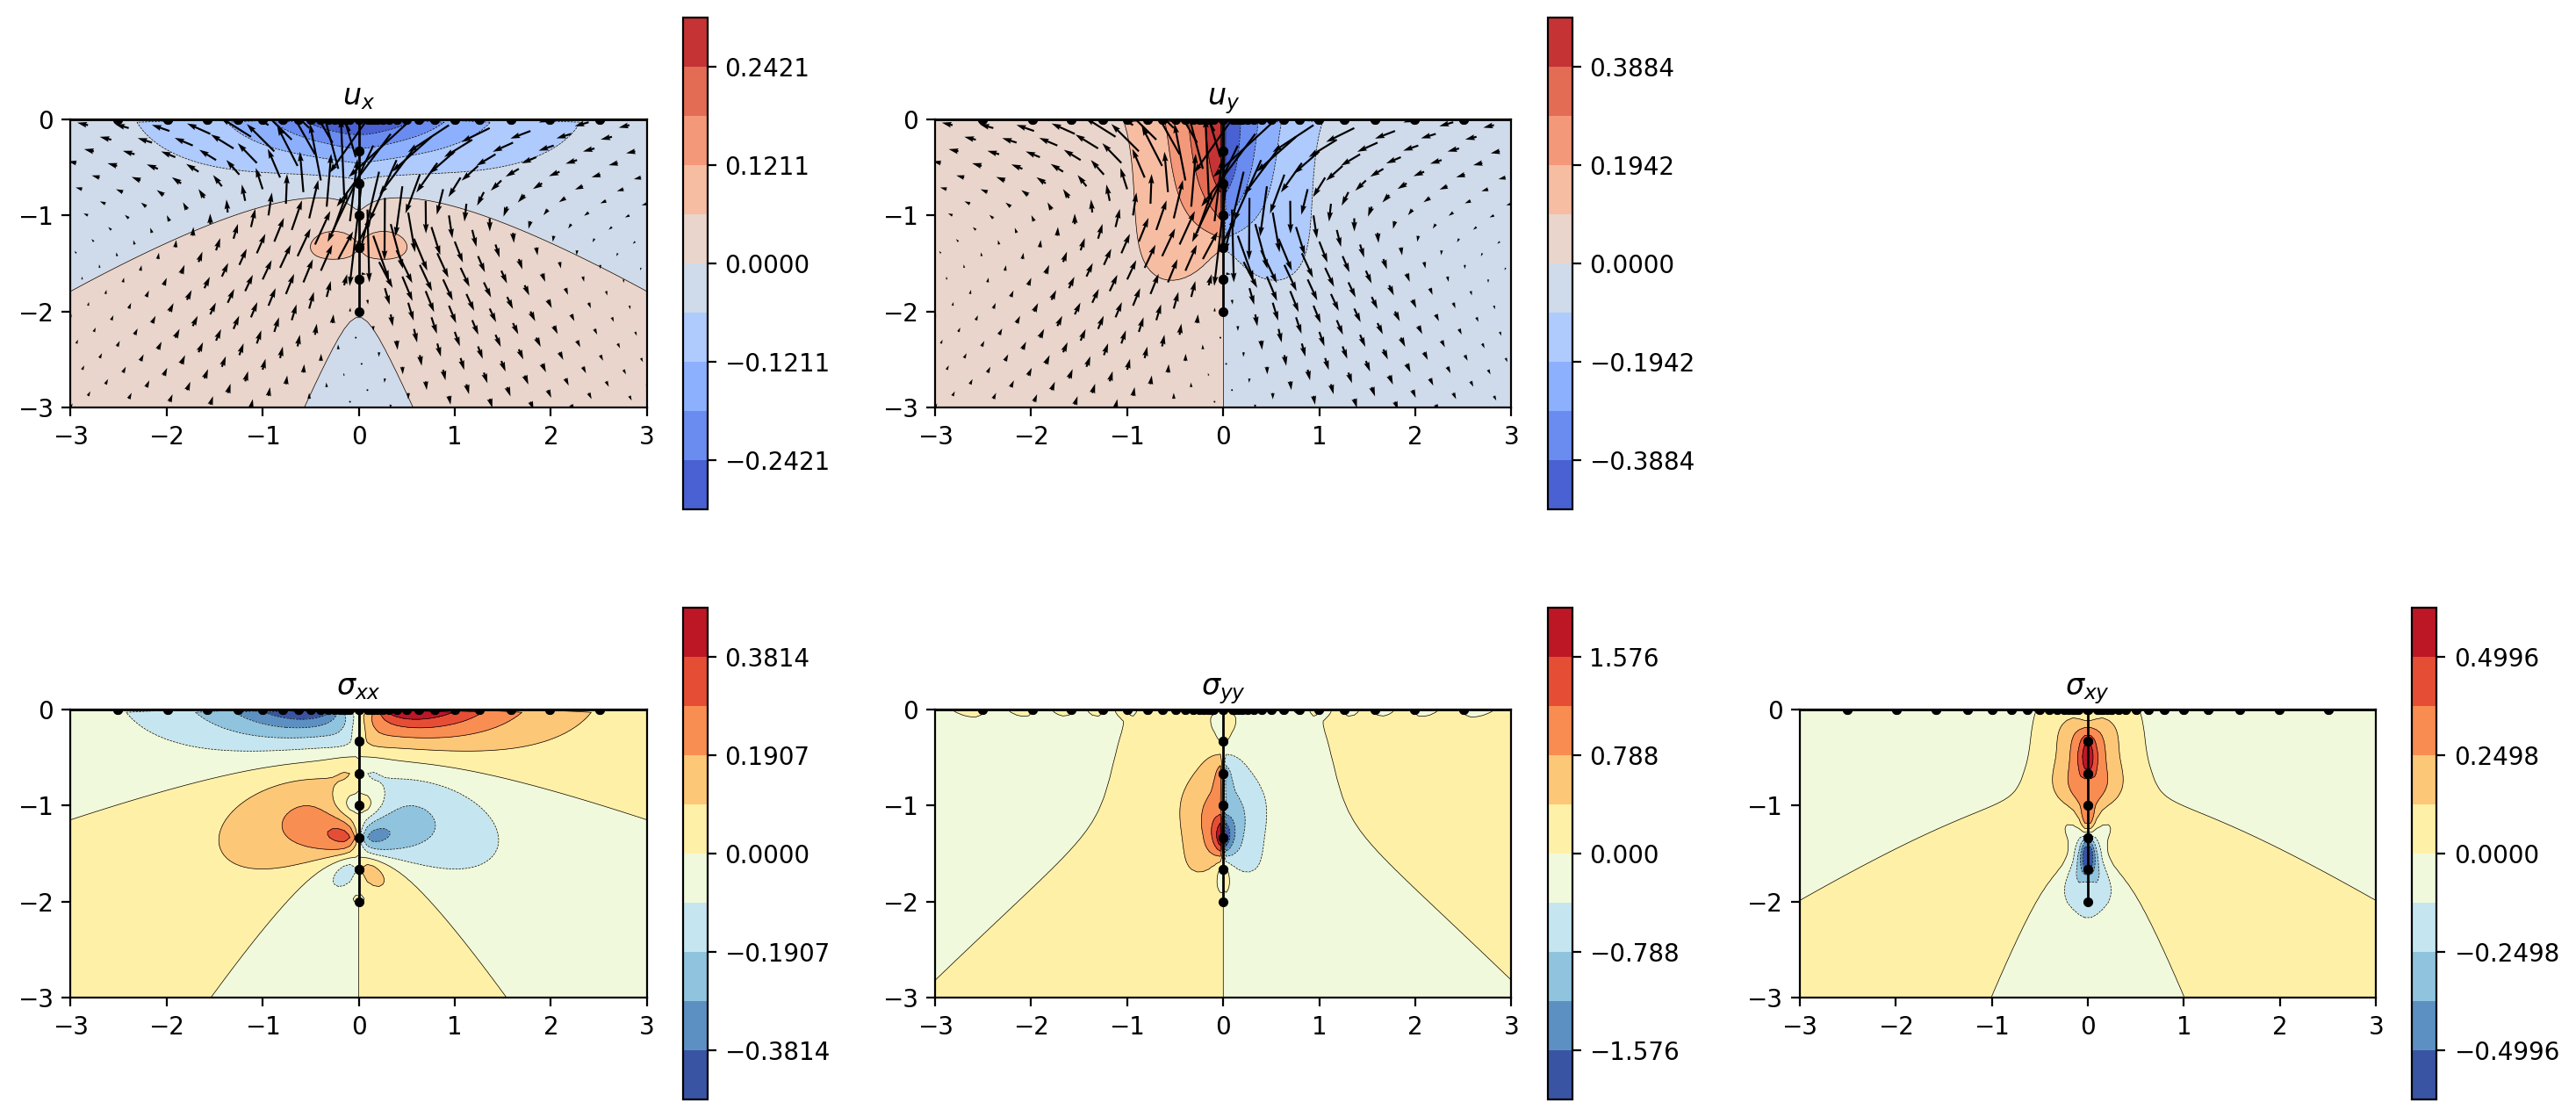

In [127]:
# Observation points
n_obs = 100
width = 3
x_obs = np.linspace(-width, width, n_obs)
y_obs = np.linspace(-width, 0, n_obs)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# Compute shear and tensile stress kernels
kernels_s = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "shear")
kernels_n = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "normal")

# Compute displacement and stresses (we will plot it later)
ux, uy, sxx, syy, sxy = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, quadratic_coefs_s, quadratic_coefs_n
)

bemcs.plot_displacements_stresses_els(
    els, n_obs, ux, uy, sxx, syy, sxy, x_obs, y_obs, n_skip_plot=31
)

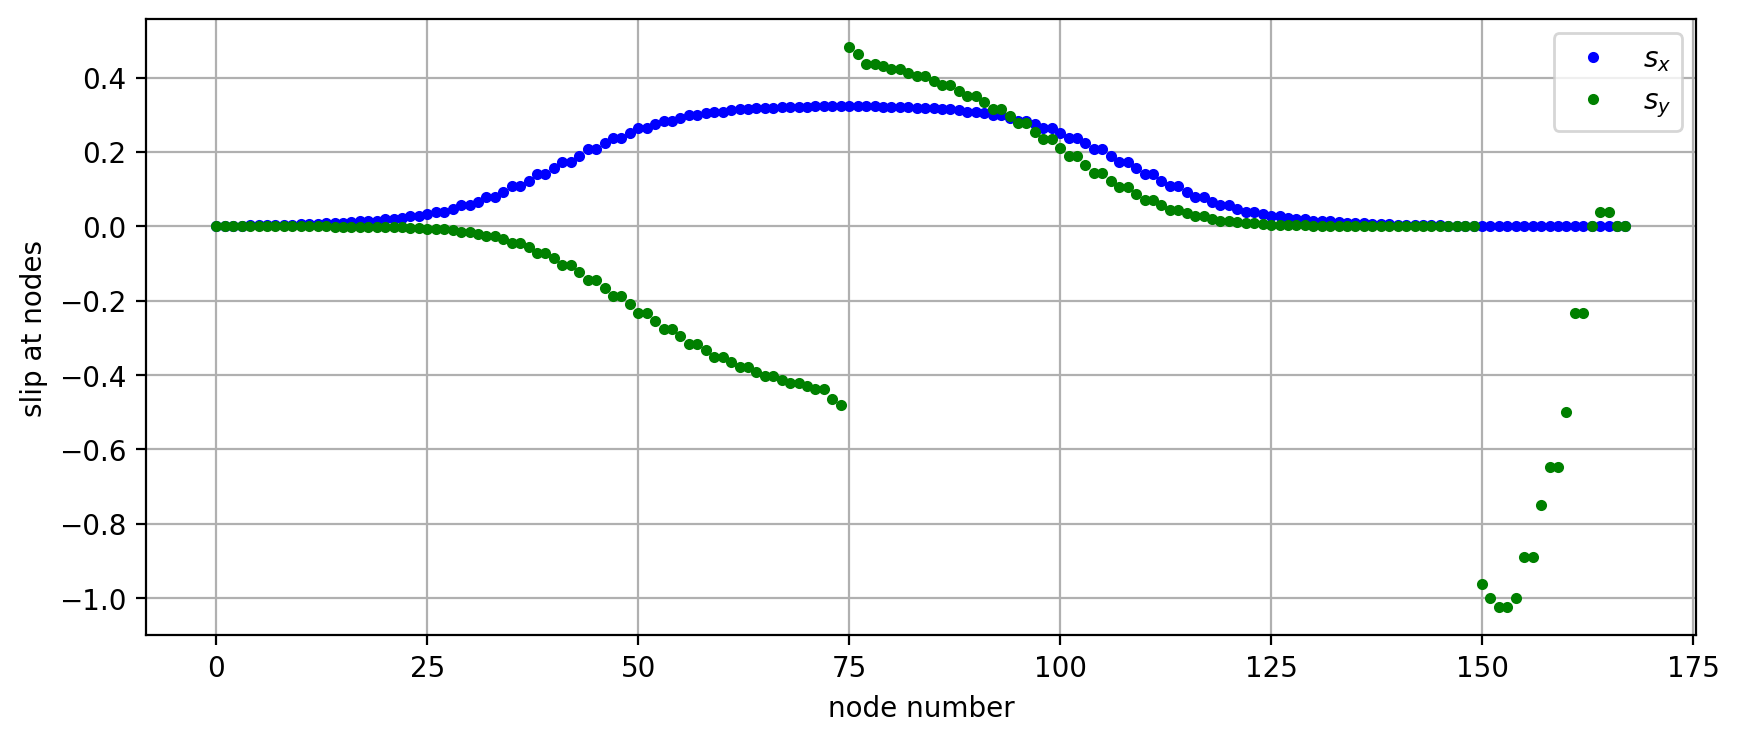

In [128]:
# Extract slip at nodes from quadratic coefficients
slip_nodes = matrix_slip @ quadratic_coefs
slip_nodes_x = slip_nodes[0::2]
slip_nodes_y = slip_nodes[1::2]
slip_vector = np.hstack((slip_nodes_x, slip_nodes_y))

# Rotate from (x,y) to (s,n) for slip vector
slip_nodes_s = np.zeros((3 * n_els, 1))
slip_nodes_n = np.zeros((3 * n_els, 1))

for i in range(n_els):
    dummy = slip_vector[3 * i : 3 * (i + 1), :] @ els.rot_mats[i, :, :]
    slip_nodes_s[3 * i : 3 * (i + 1), 0] = dummy[:, 0]
    slip_nodes_n[3 * i : 3 * (i + 1), 0] = dummy[:, 1]

plt.figure(figsize=(10, 4))
plt.plot(slip_nodes_x, "b.", label="$s_x$")
plt.plot(slip_nodes_y, "g.", label="$s_y$")
plt.xlabel("node number")
plt.ylabel("slip at nodes")
plt.legend()
plt.grid()
plt.show()